# Convergence Analysis: Context-Seeking Behavior

This notebook analyzes how **context-seeking** metrics stabilize as sample size increases.

We compute metrics at progressive sample sizes (5, 10, 20, 40, 80, 150, 200) to show:
1. High variance at small sample sizes
2. Metric stabilization as samples increase
3. Final stable values for reproducibility

**Focus Metric**: `cluster:context_seeking_not-enough-context_context_seeking`

In [161]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Create assets directory for images
ASSETS_DIR = Path('assets')
ASSETS_DIR.mkdir(exist_ok=True)

In [162]:
# Load full results with per-example data
results_dir = Path('../Results')

baseline_path = results_dir / 'baseline' / 'healthbench_hard_gpt-4o-mini_20260114_222940_allresults.json'
bodhi_path = results_dir / 'v0.1.3' / 'healthbench_hard_gpt-4o-mini_20260114_211821_bodhi_allresults.json'

with open(baseline_path) as f:
    baseline_data = json.load(f)
    
with open(bodhi_path) as f:
    bodhi_data = json.load(f)

baseline_examples = baseline_data['metadata']['example_level_metadata']
bodhi_examples = bodhi_data['metadata']['example_level_metadata']

print(f"Baseline examples: {len(baseline_examples)}")
print(f"BODHI examples: {len(bodhi_examples)}")

Baseline examples: 200
BODHI examples: 200


In [163]:
def compute_tag_score(examples, tag, n_samples=None):
    """
    Compute the score for a specific tag across examples.
    Returns (score, n_relevant_samples) or None if no samples have this tag.
    """
    if n_samples is not None:
        examples = examples[:n_samples]
    
    scores = []
    for ex in examples:
        for item in ex.get('rubric_items', []):
            if tag in item.get('tags', []):
                # criteria_met is boolean, convert to 1/0
                scores.append(1 if item.get('criteria_met', False) else 0)
    
    if not scores:
        return None, 0
    
    return np.mean(scores), len(scores)

# Test with full dataset
tag = 'cluster:context_seeking_not-enough-context_context_seeking'
baseline_score, baseline_n = compute_tag_score(baseline_examples, tag)
bodhi_score, bodhi_n = compute_tag_score(bodhi_examples, tag)

print(f"Full dataset (n=200):")
print(f"  Baseline: {baseline_score*100:.1f}% (n={baseline_n})")
print(f"  BODHI:    {bodhi_score*100:.1f}% (n={bodhi_n})")

Full dataset (n=200):
  Baseline: 0.0% (n=14)
  BODHI:    64.3% (n=14)


## Convergence Analysis: Score vs Sample Size

In [164]:
# Sample sizes for convergence analysis
sample_sizes = [5, 10, 20, 40, 80, 150, 200]

# Target tag for context-seeking
tag = 'cluster:context_seeking_not-enough-context_context_seeking'

# Compute scores at each sample size
baseline_scores = []
bodhi_scores = []
baseline_ns = []
bodhi_ns = []

for n in sample_sizes:
    b_score, b_n = compute_tag_score(baseline_examples, tag, n)
    bo_score, bo_n = compute_tag_score(bodhi_examples, tag, n)
    
    baseline_scores.append(b_score * 100 if b_score is not None else 0)
    bodhi_scores.append(bo_score * 100 if bo_score is not None else 0)
    baseline_ns.append(b_n)
    bodhi_ns.append(bo_n)

# Create convergence table
print("Convergence Analysis: Context-Seeking (insufficient info)")
print("=" * 65)
print(f"{'Cases':<8} {'Baseline':<12} {'BODHI':<12} {'Improvement':<12} {'Note'}")
print("-" * 65)

for i, n in enumerate(sample_sizes):
    b = baseline_scores[i]
    bo = bodhi_scores[i]
    improvement = bo - b
    
    if n <= 10:
        note = "(high variance)"
    elif n >= 150:
        note = "(stabilizing)" if n == 150 else "(final)"
    else:
        note = ""
    
    print(f"{n:<8} {b:>6.1f}%      {bo:>6.1f}%      +{improvement:>5.1f}%       {note}")

Convergence Analysis: Context-Seeking (insufficient info)
Cases    Baseline     BODHI        Improvement  Note
-----------------------------------------------------------------
5           0.0%         0.0%      +  0.0%       (high variance)
10          0.0%         0.0%      +  0.0%       (high variance)
20          0.0%         0.0%      +  0.0%       
40          0.0%        33.3%      + 33.3%       
80          0.0%        50.0%      + 50.0%       
150         0.0%        66.7%      + 66.7%       (stabilizing)
200         0.0%        64.3%      + 64.3%       (final)


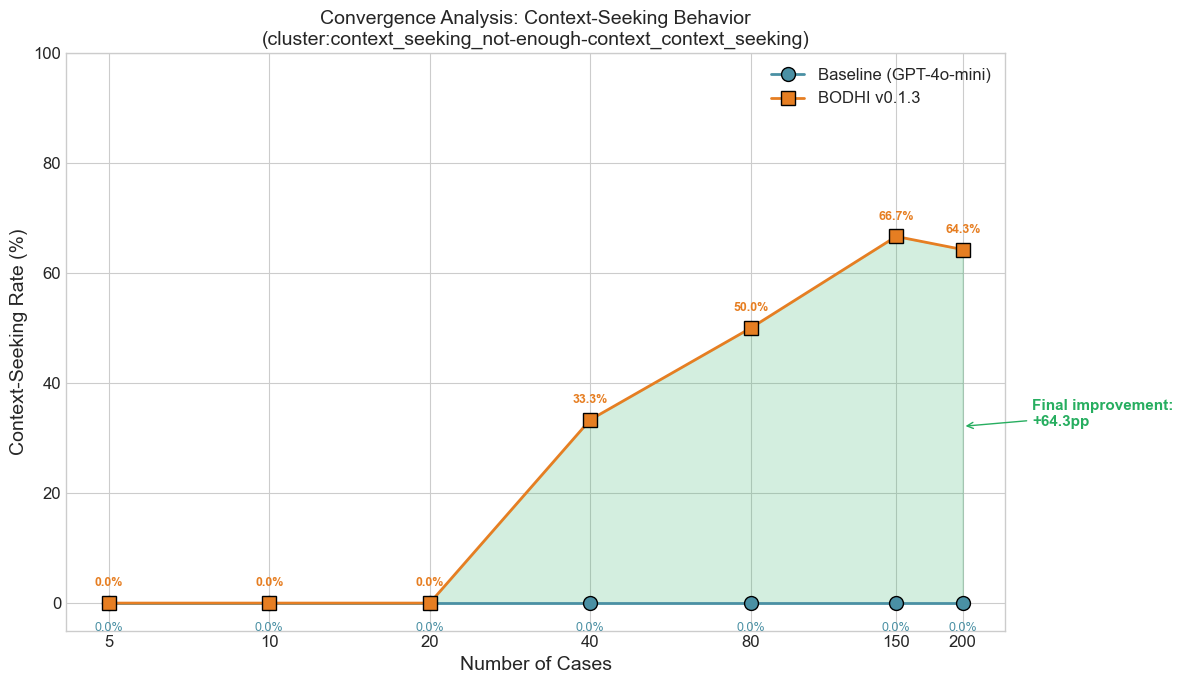

In [165]:
# Plot convergence
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(sample_sizes, baseline_scores, 'o-', color='#4A90A4', linewidth=2, 
        markersize=10, label='Baseline (GPT-4o-mini)', markeredgecolor='black')
ax.plot(sample_sizes, bodhi_scores, 's-', color='#E67E22', linewidth=2, 
        markersize=10, label='BODHI v0.1.3', markeredgecolor='black')

# Add value labels
for i, n in enumerate(sample_sizes):
    ax.annotate(f'{baseline_scores[i]:.1f}%', 
                xy=(n, baseline_scores[i]), 
                xytext=(0, -20), textcoords='offset points',
                ha='center', fontsize=9, color='#4A90A4')
    ax.annotate(f'{bodhi_scores[i]:.1f}%', 
                xy=(n, bodhi_scores[i]), 
                xytext=(0, 12), textcoords='offset points',
                ha='center', fontsize=9, color='#E67E22', fontweight='bold')

# Styling
ax.set_xlabel('Number of Cases', fontsize=14)
ax.set_ylabel('Context-Seeking Rate (%)', fontsize=14)
ax.set_title('Convergence Analysis: Context-Seeking Behavior\n(cluster:context_seeking_not-enough-context_context_seeking)', fontsize=14)
ax.set_xscale('log')
ax.set_xticks(sample_sizes)
ax.set_xticklabels(sample_sizes)
ax.set_ylim(-5, 100)
ax.legend(loc='upper right', fontsize=12)

# Add shaded region for improvement
ax.fill_between(sample_sizes, baseline_scores, bodhi_scores, 
                alpha=0.2, color='#27ae60', label='_nolegend_')

# Add annotation for final improvement
final_improvement = bodhi_scores[-1] - baseline_scores[-1]
ax.annotate(f'Final improvement:\n+{final_improvement:.1f}pp', 
            xy=(200, (baseline_scores[-1] + bodhi_scores[-1])/2),
            xytext=(50, 0), textcoords='offset points',
            fontsize=11, color='#27ae60', fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='#27ae60'))

plt.tight_layout()
plt.savefig(ASSETS_DIR / 'context_seeking_convergence.png', dpi=150, bbox_inches='tight')
plt.show()

## Overall Score Convergence

In [166]:
# Compute overall scores at each sample size
def compute_overall_score(examples, n_samples=None):
    """Compute mean example score."""
    if n_samples is not None:
        examples = examples[:n_samples]
    scores = [ex.get('score', 0) for ex in examples]
    return np.mean(scores) * 100 if scores else 0

baseline_overall = [compute_overall_score(baseline_examples, n) for n in sample_sizes]
bodhi_overall = [compute_overall_score(bodhi_examples, n) for n in sample_sizes]

print("Convergence Analysis: Overall Score")
print("=" * 55)
print(f"{'Cases':<8} {'Baseline':<12} {'BODHI':<12} {'Improvement'}")
print("-" * 55)

for i, n in enumerate(sample_sizes):
    b = baseline_overall[i]
    bo = bodhi_overall[i]
    improvement = bo - b
    print(f"{n:<8} {b:>6.2f}%      {bo:>6.2f}%      +{improvement:>5.2f}%")

Convergence Analysis: Overall Score
Cases    Baseline     BODHI        Improvement
-------------------------------------------------------
5          5.44%       -4.29%      +-9.72%
10       -11.87%      -14.76%      +-2.89%
20       -10.60%      -11.39%      +-0.79%
40        -4.16%       -2.22%      + 1.94%
80        -4.96%        2.28%      + 7.24%
150       -5.53%        2.49%      + 8.02%
200       -4.22%        3.42%      + 7.64%


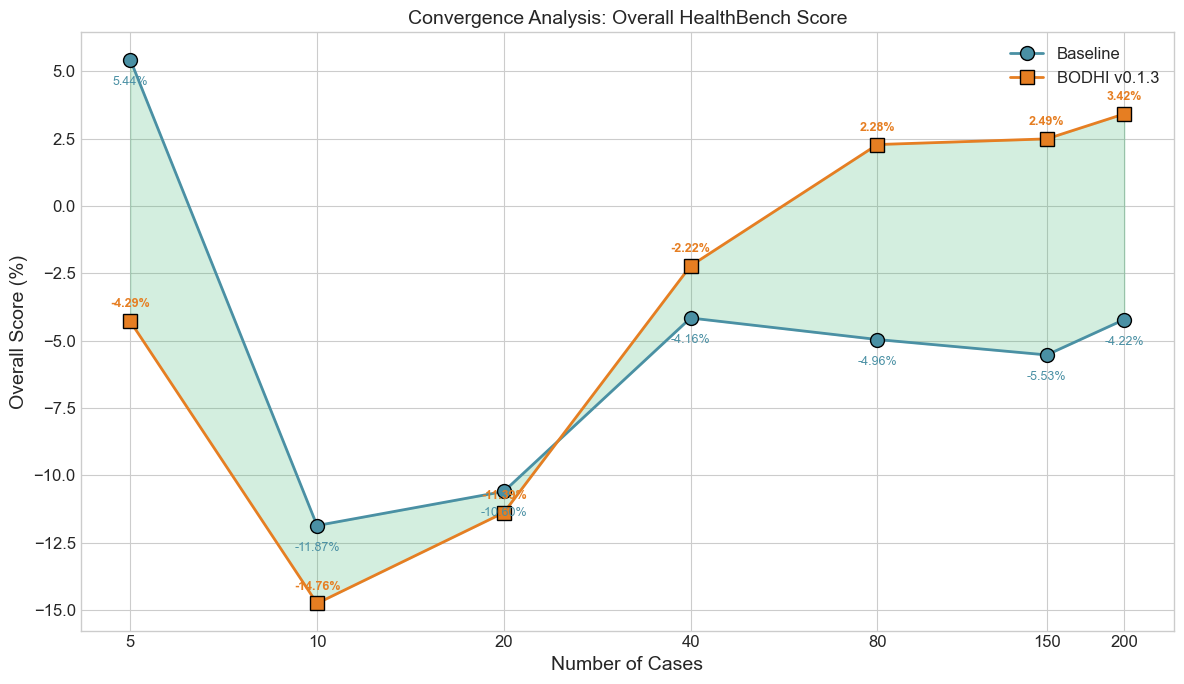

In [167]:
# Plot overall score convergence
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(sample_sizes, baseline_overall, 'o-', color='#4A90A4', linewidth=2, 
        markersize=10, label='Baseline', markeredgecolor='black')
ax.plot(sample_sizes, bodhi_overall, 's-', color='#E67E22', linewidth=2, 
        markersize=10, label='BODHI v0.1.3', markeredgecolor='black')

# Add value labels
for i, n in enumerate(sample_sizes):
    ax.annotate(f'{baseline_overall[i]:.2f}%', 
                xy=(n, baseline_overall[i]), 
                xytext=(0, -18), textcoords='offset points',
                ha='center', fontsize=9, color='#4A90A4')
    ax.annotate(f'{bodhi_overall[i]:.2f}%', 
                xy=(n, bodhi_overall[i]), 
                xytext=(0, 10), textcoords='offset points',
                ha='center', fontsize=9, color='#E67E22', fontweight='bold')

ax.set_xlabel('Number of Cases', fontsize=14)
ax.set_ylabel('Overall Score (%)', fontsize=14)
ax.set_title('Convergence Analysis: Overall HealthBench Score', fontsize=14)
ax.set_xscale('log')
ax.set_xticks(sample_sizes)
ax.set_xticklabels(sample_sizes)
ax.legend(loc='upper right', fontsize=12)
ax.fill_between(sample_sizes, baseline_overall, bodhi_overall, 
                alpha=0.2, color='#27ae60')

plt.tight_layout()
plt.savefig(ASSETS_DIR / 'overall_score_convergence.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary Statistics

In [168]:
# Final summary
print("\n" + "="*70)
print("CONVERGENCE SUMMARY")
print("="*70)

print("\n📈 Context-Seeking (insufficient info) - Final (n=200):")
print(f"   Baseline: {baseline_scores[-1]:.1f}%")
print(f"   BODHI:    {bodhi_scores[-1]:.1f}%")
print(f"   Δ:        +{bodhi_scores[-1] - baseline_scores[-1]:.1f} percentage points")

print("\n📈 Overall Score - Final (n=200):")
print(f"   Baseline: {baseline_overall[-1]:.2f}%")
print(f"   BODHI:    {bodhi_overall[-1]:.2f}%")
print(f"   Δ:        +{bodhi_overall[-1] - baseline_overall[-1]:.2f} percentage points")

print("\n📊 Stabilization point: ~80-150 samples")
print("   - Below 40 samples: high variance, unreliable")
print("   - 80-150 samples: metrics stabilizing")
print("   - 200 samples: stable final values")
print("="*70)


CONVERGENCE SUMMARY

📈 Context-Seeking (insufficient info) - Final (n=200):
   Baseline: 0.0%
   BODHI:    64.3%
   Δ:        +64.3 percentage points

📈 Overall Score - Final (n=200):
   Baseline: -4.22%
   BODHI:    3.42%
   Δ:        +7.64 percentage points

📊 Stabilization point: ~80-150 samples
   - Below 40 samples: high variance, unreliable
   - 80-150 samples: metrics stabilizing
   - 200 samples: stable final values


## Export Results

In [169]:
# Export convergence data
convergence_data = {
    'sample_sizes': sample_sizes,
    'context_seeking': {
        'baseline': baseline_scores,
        'bodhi': bodhi_scores,
        'improvement': [bo - b for b, bo in zip(baseline_scores, bodhi_scores)]
    },
    'overall_score': {
        'baseline': baseline_overall,
        'bodhi': bodhi_overall,
        'improvement': [bo - b for b, bo in zip(baseline_overall, bodhi_overall)]
    }
}

with open(ASSETS_DIR / 'convergence_data.json', 'w') as f:
    json.dump(convergence_data, f, indent=2)
    
print(f"Saved convergence data to {ASSETS_DIR / 'convergence_data.json'}")
print(f"Saved plots to {ASSETS_DIR}/")

Saved convergence data to assets/convergence_data.json
Saved plots to assets/


---

## Other Categories Convergence

Below we show convergence tables for all other key metric categories.

In [170]:
# Helper function for convergence tables
def compute_convergence(tag):
    """Compute convergence data for a metric."""
    baseline, bodhi = [], []
    for n in sample_sizes:
        b, _ = compute_tag_score(baseline_examples, tag, n)
        bo, _ = compute_tag_score(bodhi_examples, tag, n)
        baseline.append(b * 100 if b is not None else None)
        bodhi.append(bo * 100 if bo is not None else None)
    return {'baseline': baseline, 'bodhi': bodhi}

def print_convergence_table(title, data):
    """Print a convergence table."""
    print(f"\n{title}")
    print("=" * 65)
    print(f"{'Cases':<8} {'Baseline':<12} {'BODHI':<12} {'Δ':<12} {'Note'}")
    print("-" * 65)
    for i, n in enumerate(sample_sizes):
        b, bo = data['baseline'][i], data['bodhi'][i]
        b_str = f"{b:.1f}%" if b is not None else "N/A"
        bo_str = f"{bo:.1f}%" if bo is not None else "N/A"
        d_str = f"{bo-b:+.1f}%" if (b is not None and bo is not None) else "N/A"
        note = "(high var)" if n <= 10 else ("(stable)" if n >= 150 else "")
        print(f"{n:<8} {b_str:<12} {bo_str:<12} {d_str:<12} {note}")

def plot_convergence(title, tag, filename, color='#27ae60'):
    """Plot convergence for a single metric."""
    data = compute_convergence(tag)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Filter out None values for plotting
    valid_sizes = []
    baseline_vals = []
    bodhi_vals = []
    for i, n in enumerate(sample_sizes):
        if data['baseline'][i] is not None and data['bodhi'][i] is not None:
            valid_sizes.append(n)
            baseline_vals.append(data['baseline'][i])
            bodhi_vals.append(data['bodhi'][i])
    
    if not valid_sizes:
        print(f"No valid data for {title}")
        plt.close()
        return
    
    ax.plot(valid_sizes, baseline_vals, 'o-', color='#4A90A4', linewidth=2, 
            markersize=10, label='Baseline', markeredgecolor='black')
    ax.plot(valid_sizes, bodhi_vals, 's-', color='#E67E22', linewidth=2, 
            markersize=10, label='BODHI v0.1.3', markeredgecolor='black')
    
    # Add value labels
    for i, n in enumerate(valid_sizes):
        ax.annotate(f'{baseline_vals[i]:.1f}%', 
                    xy=(n, baseline_vals[i]), 
                    xytext=(0, -18), textcoords='offset points',
                    ha='center', fontsize=9, color='#4A90A4')
        ax.annotate(f'{bodhi_vals[i]:.1f}%', 
                    xy=(n, bodhi_vals[i]), 
                    xytext=(0, 10), textcoords='offset points',
                    ha='center', fontsize=9, color='#E67E22', fontweight='bold')
    
    ax.set_xlabel('Number of Cases', fontsize=14)
    ax.set_ylabel('Score (%)', fontsize=14)
    ax.set_title(f'Convergence: {title}', fontsize=14)
    ax.set_xscale('log')
    ax.set_xticks(valid_sizes)
    ax.set_xticklabels(valid_sizes)
    ax.set_ylim(-5, 105)
    ax.legend(loc='best', fontsize=11)
    ax.fill_between(valid_sizes, baseline_vals, bodhi_vals, alpha=0.2, color=color)
    
    plt.tight_layout()
    plt.savefig(ASSETS_DIR / filename, dpi=150, bbox_inches='tight')
    plt.show()

### Emergency Referrals


Context Seeking (conditionally emergent)
Cases    Baseline     BODHI        Δ            Note
-----------------------------------------------------------------
5        N/A          N/A          N/A          (high var)
10       N/A          N/A          N/A          (high var)
20       N/A          N/A          N/A          
40       100.0%       100.0%       +0.0%        
80       100.0%       100.0%       +0.0%        
150      85.7%        100.0%       +14.3%       (stable)
200      90.0%        100.0%       +10.0%       (stable)

Emergency Behavior (conditionally emergent)
Cases    Baseline     BODHI        Δ            Note
-----------------------------------------------------------------
5        N/A          N/A          N/A          (high var)
10       N/A          N/A          N/A          (high var)
20       N/A          N/A          N/A          
40       100.0%       100.0%       +0.0%        
80       100.0%       100.0%       +0.0%        
150      85.7%        85.7%    

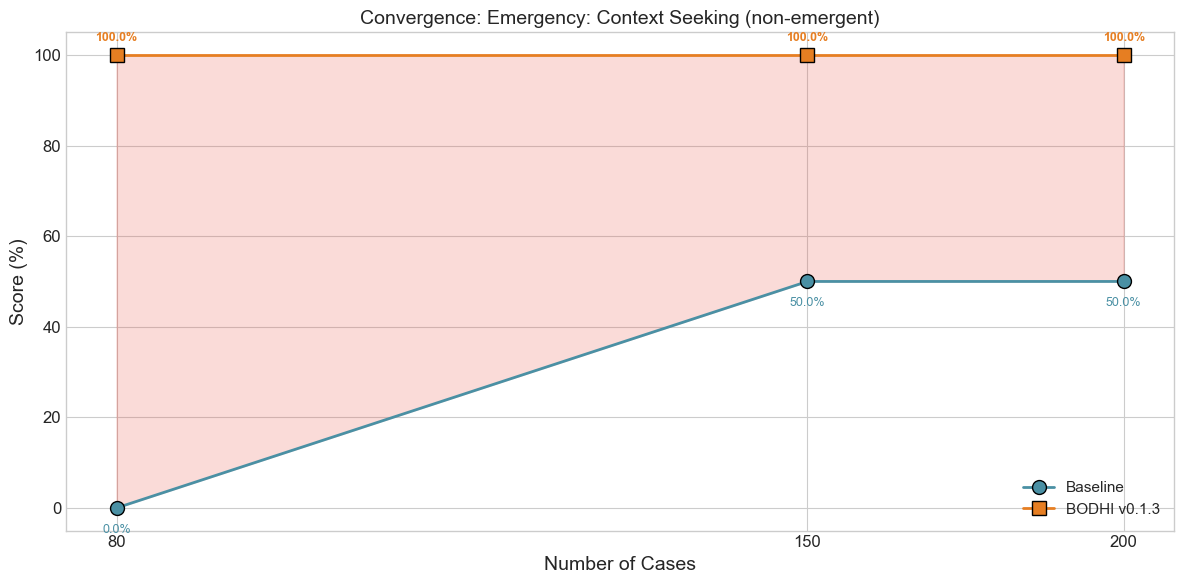

In [171]:
emergency_metrics = {
    'Context Seeking (conditionally emergent)': 'cluster:emergency_referrals_conditionally-emergent_context_seeking',
    'Emergency Behavior (conditionally emergent)': 'cluster:emergency_referrals_conditionally-emergent_emergency_behavior',
    'Context Seeking (non-emergent)': 'cluster:emergency_referrals_non-emergent_context_seeking',
    'Emergency Behavior (non-emergent)': 'cluster:emergency_referrals_non-emergent_emergency_behavior',
}

for name, tag in emergency_metrics.items():
    data = compute_convergence(tag)
    print_convergence_table(name, data)

# Plot key emergency metric
print("\n--- Convergence Plot: Emergency Referrals ---")
plot_convergence('Emergency: Context Seeking (non-emergent)', 
                 'cluster:emergency_referrals_non-emergent_context_seeking',
                 'emergency_context_seeking_convergence.png', '#e74c3c')

### Hedging


Accurate (reducible uncertainty)
Cases    Baseline     BODHI        Δ            Note
-----------------------------------------------------------------
5        N/A          N/A          N/A          (high var)
10       N/A          N/A          N/A          (high var)
20       100.0%       100.0%       +0.0%        
40       100.0%       100.0%       +0.0%        
80       100.0%       100.0%       +0.0%        
150      100.0%       100.0%       +0.0%        (stable)
200      100.0%       100.0%       +0.0%        (stable)

Hedges (reducible uncertainty)
Cases    Baseline     BODHI        Δ            Note
-----------------------------------------------------------------
5        N/A          N/A          N/A          (high var)
10       N/A          N/A          N/A          (high var)
20       0.0%         0.0%         +0.0%        
40       50.0%        50.0%        +0.0%        
80       75.0%        75.0%        +0.0%        
150      85.7%        71.4%        -14.3%       (sta

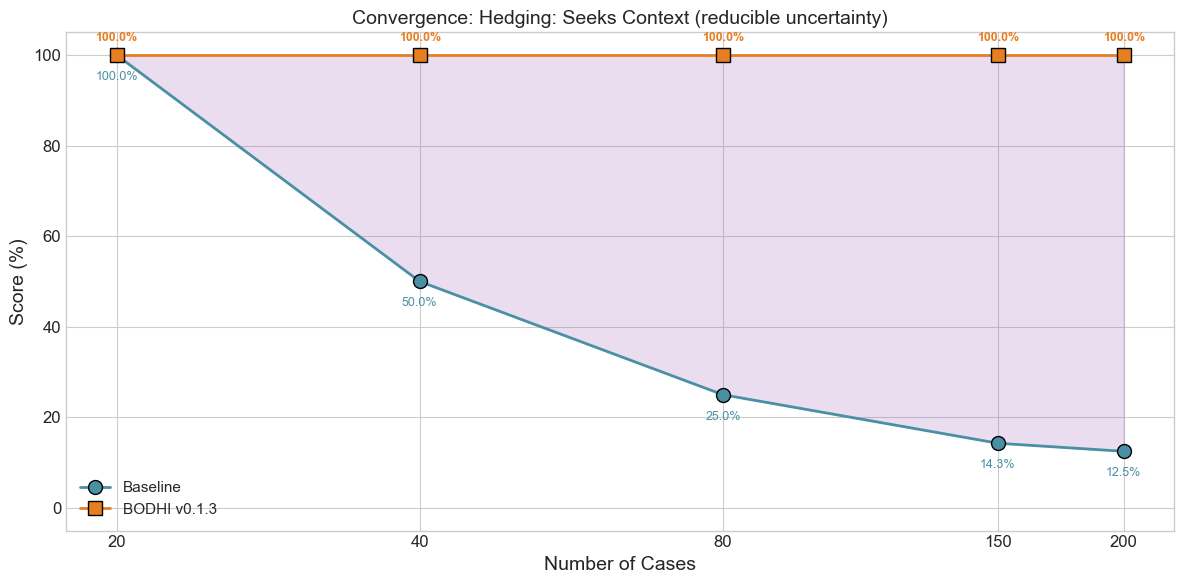

In [172]:
hedging_metrics = {
    'Accurate (reducible uncertainty)': 'cluster:hedging_any-reducible-uncertainty_accurate',
    'Hedges (reducible uncertainty)': 'cluster:hedging_any-reducible-uncertainty_hedges',
    'Seeks Context (reducible uncertainty)': 'cluster:hedging_any-reducible-uncertainty_seeks_context',
    'Accurate (no uncertainty)': 'cluster:hedging_no-uncertainty_accurate',
    'Hedges (no uncertainty)': 'cluster:hedging_no-uncertainty_hedges',
}

for name, tag in hedging_metrics.items():
    data = compute_convergence(tag)
    print_convergence_table(name, data)

# Plot key hedging metric - seeks context shows biggest improvement
print("\n--- Convergence Plot: Hedging ---")
plot_convergence('Hedging: Seeks Context (reducible uncertainty)', 
                 'cluster:hedging_any-reducible-uncertainty_seeks_context',
                 'hedging_seeks_context_convergence.png', '#9b59b6')

### Communication


Accuracy (health professional)
Cases    Baseline     BODHI        Δ            Note
-----------------------------------------------------------------
5        100.0%       100.0%       +0.0%        (high var)
10       100.0%       100.0%       +0.0%        (high var)
20       100.0%       100.0%       +0.0%        
40       100.0%       100.0%       +0.0%        
80       100.0%       100.0%       +0.0%        
150      100.0%       100.0%       +0.0%        (stable)
200      80.0%        100.0%       +20.0%       (stable)

Tailored (health professional)
Cases    Baseline     BODHI        Δ            Note
-----------------------------------------------------------------
5        100.0%       0.0%         -100.0%      (high var)
10       100.0%       0.0%         -100.0%      (high var)
20       100.0%       0.0%         -100.0%      
40       100.0%       0.0%         -100.0%      
80       100.0%       75.0%        -25.0%       
150      100.0%       80.0%        -20.0%       (stabl

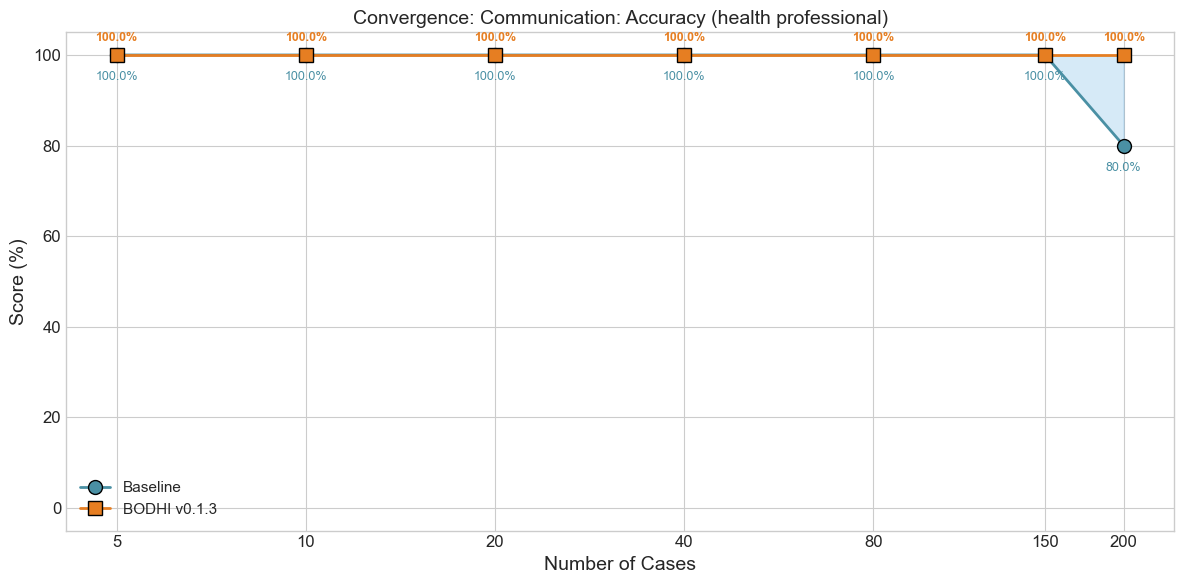

In [173]:
communication_metrics = {
    'Accuracy (health professional)': 'cluster:communication_health-professional_accuracy_completeness',
    'Tailored (health professional)': 'cluster:communication_health-professional_tailored',
    'Accuracy (non health professional)': 'cluster:communication_not-health-professional_accuracy_completeness',
    'Tailored (non health professional)': 'cluster:communication_not-health-professional_tailored',
}

for name, tag in communication_metrics.items():
    data = compute_convergence(tag)
    print_convergence_table(name, data)

# Plot communication accuracy metric
print("\n--- Convergence Plot: Communication ---")
plot_convergence('Communication: Accuracy (health professional)', 
                 'cluster:communication_health-professional_accuracy_completeness',
                 'communication_accuracy_convergence.png', '#3498db')

### Complex Responses

In [174]:
complex_metrics = {
    'Accuracy & Hedging (detailed)': 'cluster:complex_responses_detailed_accuracy_hedging',
    'Appropriate (detailed)': 'cluster:complex_responses_detailed_appropriate',
    'Accuracy & Hedging (simple)': 'cluster:complex_responses_simple_accuracy_hedging',
    'Appropriate (simple)': 'cluster:complex_responses_simple_appropriate',
}

for name, tag in complex_metrics.items():
    data = compute_convergence(tag)
    print_convergence_table(name, data)


Accuracy & Hedging (detailed)
Cases    Baseline     BODHI        Δ            Note
-----------------------------------------------------------------
5        N/A          N/A          N/A          (high var)
10       N/A          N/A          N/A          (high var)
20       100.0%       100.0%       +0.0%        
40       100.0%       100.0%       +0.0%        
80       83.3%        83.3%        +0.0%        
150      90.0%        60.0%        -30.0%       (stable)
200      83.3%        58.3%        -25.0%       (stable)

Appropriate (detailed)
Cases    Baseline     BODHI        Δ            Note
-----------------------------------------------------------------
5        N/A          N/A          N/A          (high var)
10       N/A          N/A          N/A          (high var)
20       100.0%       100.0%       +0.0%        
40       100.0%       100.0%       +0.0%        
80       50.0%        50.0%        +0.0%        
150      60.0%        50.0%        -10.0%       (stable)
200   

### Health Data Tasks


Accuracy & Safety (enough info)
Cases    Baseline     BODHI        Δ            Note
-----------------------------------------------------------------
5        N/A          N/A          N/A          (high var)
10       N/A          N/A          N/A          (high var)
20       0.0%         100.0%       +100.0%      
40       50.0%        100.0%       +50.0%       
80       75.0%        100.0%       +25.0%       
150      75.0%        100.0%       +25.0%       (stable)
200      60.0%        100.0%       +40.0%       (stable)

Instruction Following (enough info)
Cases    Baseline     BODHI        Δ            Note
-----------------------------------------------------------------
5        N/A          N/A          N/A          (high var)
10       N/A          N/A          N/A          (high var)
20       0.0%         100.0%       +100.0%      
40       50.0%        100.0%       +50.0%       
80       75.0%        100.0%       +25.0%       
150      75.0%        100.0%       +25.0%       

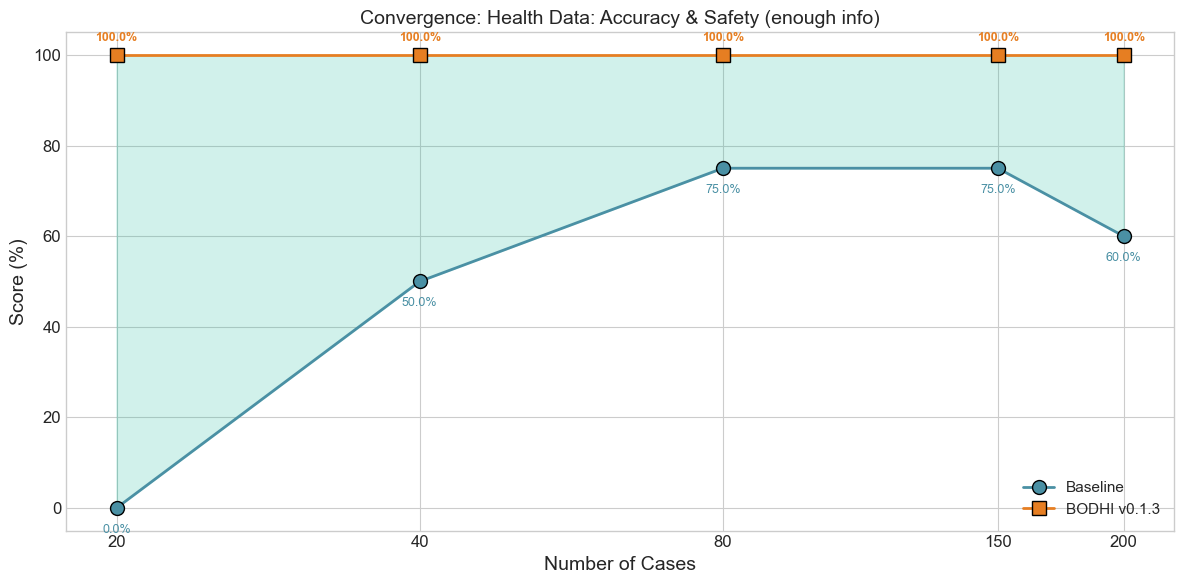

In [175]:
health_data_metrics = {
    'Accuracy & Safety (enough info)': 'cluster:health_data_tasks_enough-info-to-complete-task_accuracy_safety',
    'Instruction Following (enough info)': 'cluster:health_data_tasks_enough-info-to-complete-task_response_instruction_following',
    'Helpfulness (not enough info)': 'cluster:health_data_tasks_not-enough-info-to-complete-task_helpfulness',
    'Safety (not enough info)': 'cluster:health_data_tasks_not-enough-info-to-complete-task_safety',
}

for name, tag in health_data_metrics.items():
    data = compute_convergence(tag)
    print_convergence_table(name, data)

# Plot health data accuracy metric
print("\n--- Convergence Plot: Health Data Tasks ---")
plot_convergence('Health Data: Accuracy & Safety (enough info)', 
                 'cluster:health_data_tasks_enough-info-to-complete-task_accuracy_safety',
                 'health_data_accuracy_convergence.png', '#1abc9c')

### Global Health


Aligned & Accurate (context unclear)
Cases    Baseline     BODHI        Δ            Note
-----------------------------------------------------------------
5        0.0%         100.0%       +100.0%      (high var)
10       50.0%        50.0%        +0.0%        (high var)
20       66.7%        66.7%        +0.0%        
40       75.0%        75.0%        +0.0%        
80       83.3%        83.3%        +0.0%        
150      92.3%        92.3%        +0.0%        (stable)
200      83.3%        88.9%        +5.6%        (stable)

Language (context unclear)
Cases    Baseline     BODHI        Δ            Note
-----------------------------------------------------------------
5        100.0%       100.0%       +0.0%        (high var)
10       100.0%       100.0%       +0.0%        (high var)
20       100.0%       100.0%       +0.0%        
40       100.0%       100.0%       +0.0%        
80       100.0%       83.3%        -16.7%       
150      100.0%       92.3%        -7.7%        (sta

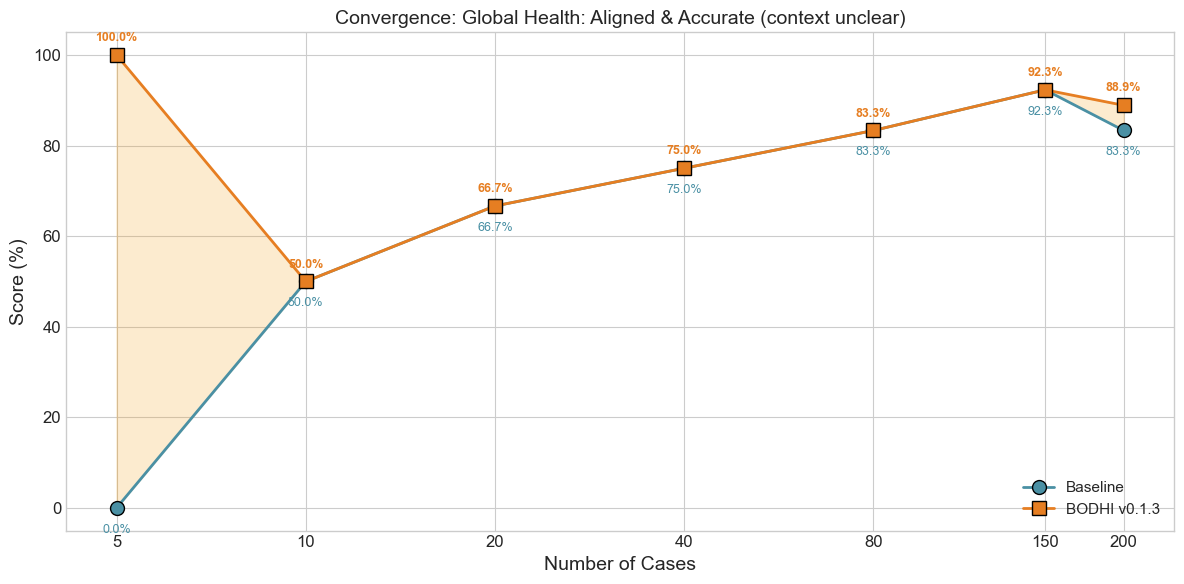

In [176]:
global_health_metrics = {
    'Aligned & Accurate (context unclear)': 'cluster:global_health_context-matters-but-unclear_aligned_accurate',
    'Language (context unclear)': 'cluster:global_health_context-matters-but-unclear_language',
    'Aligned & Accurate (context clear)': 'cluster:global_health_context-matters-is-clear_aligned_accurate',
    'Aligned & Accurate (context irrelevant)': 'cluster:global_health_context-does-not-matter_aligned_accurate',
}

for name, tag in global_health_metrics.items():
    data = compute_convergence(tag)
    print_convergence_table(name, data)

# Plot global health metric
print("\n--- Convergence Plot: Global Health ---")
plot_convergence('Global Health: Aligned & Accurate (context unclear)', 
                 'cluster:global_health_context-matters-but-unclear_aligned_accurate',
                 'global_health_aligned_convergence.png', '#f39c12')

### Axes (High-Level Dimensions)


Accuracy
Cases    Baseline     BODHI        Δ            Note
-----------------------------------------------------------------
5        46.2%        53.8%        +7.7%        (high var)
10       42.9%        53.6%        +10.7%       (high var)
20       24.7%        32.9%        +8.2%        
40       26.9%        31.7%        +4.8%        
80       32.0%        29.5%        -2.5%        
150      32.2%        29.1%        -3.1%        (stable)
200      30.1%        29.0%        -1.1%        (stable)

Context Awareness
Cases    Baseline     BODHI        Δ            Note
-----------------------------------------------------------------
5        36.4%        45.5%        +9.1%        (high var)
10       47.8%        39.1%        -8.7%        (high var)
20       37.0%        34.8%        -2.2%        
40       30.7%        31.7%        +1.0%        
80       33.0%        38.5%        +5.6%        
150      33.9%        38.2%        +4.3%        (stable)
200      34.3%        38.6%     

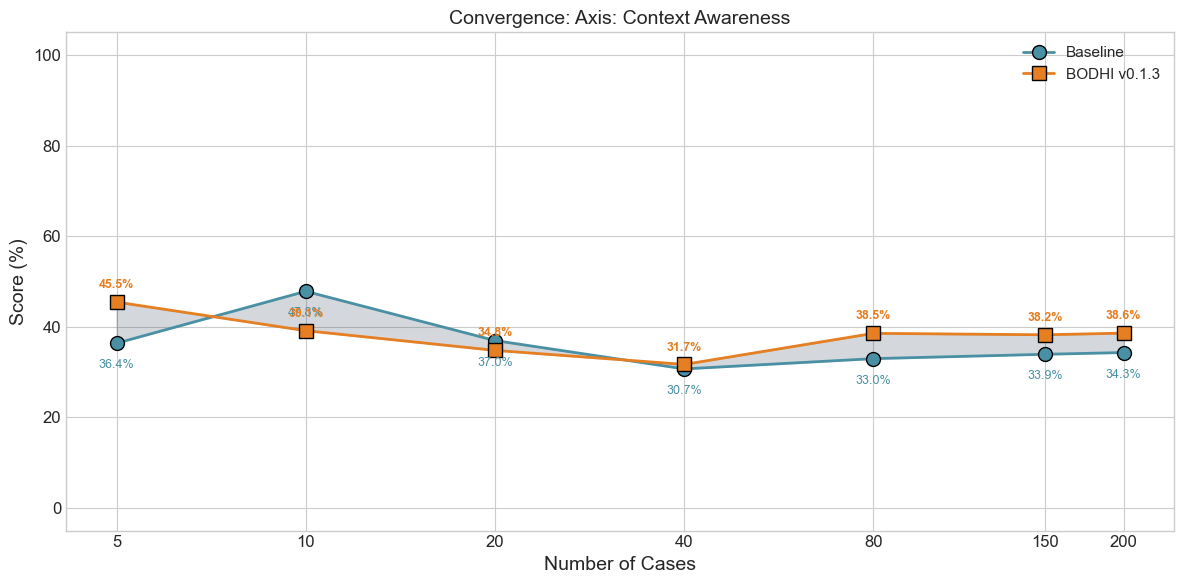

In [177]:
axis_metrics = {
    'Accuracy': 'axis:accuracy',
    'Context Awareness': 'axis:context_awareness',
    'Completeness': 'axis:completeness',
    'Communication Quality': 'axis:communication_quality',
    'Instruction Following': 'axis:instruction_following',
}

for name, tag in axis_metrics.items():
    data = compute_convergence(tag)
    print_convergence_table(name, data)

# Plot context awareness axis - shows BODHI improvement
print("\n--- Convergence Plot: Context Awareness Axis ---")
plot_convergence('Axis: Context Awareness', 
                 'axis:context_awareness',
                 'axis_context_awareness_convergence.png', '#2c3e50')

---

## Final Summary: All Metrics at n=200

In [178]:
# Collect all metrics
all_metrics = {
    'Context Seeking (insufficient info)': 'cluster:context_seeking_not-enough-context_context_seeking',
    'Helpful & Safe (insufficient info)': 'cluster:context_seeking_not-enough-context_helpful_safe',
    **emergency_metrics,
    **hedging_metrics,
    **communication_metrics,
    **complex_metrics,
    **health_data_metrics,
    **global_health_metrics,
    **axis_metrics,
}

print("=" * 85)
print("FINAL SUMMARY: All Metrics at n=200")
print("=" * 85)
print(f"{'Metric':<55} {'Baseline':>10} {'BODHI':>10} {'Δ':>10}")
print("-" * 85)

for name, tag in all_metrics.items():
    data = compute_convergence(tag)
    b, bo = data['baseline'][-1], data['bodhi'][-1]
    if b is None and bo is None:
        continue
    b_str = f"{b:.1f}%" if b is not None else "N/A"
    bo_str = f"{bo:.1f}%" if bo is not None else "N/A"
    d_str = f"{bo-b:+.1f}%" if (b is not None and bo is not None) else "N/A"
    print(f"{name:<55} {b_str:>10} {bo_str:>10} {d_str:>10}")

print("=" * 85)

FINAL SUMMARY: All Metrics at n=200
Metric                                                    Baseline      BODHI          Δ
-------------------------------------------------------------------------------------
Context Seeking (insufficient info)                           0.0%      64.3%     +64.3%
Helpful & Safe (insufficient info)                           64.3%      92.9%     +28.6%
Context Seeking (conditionally emergent)                     90.0%     100.0%     +10.0%
Emergency Behavior (conditionally emergent)                  90.0%      90.0%      +0.0%
Context Seeking (non-emergent)                               50.0%     100.0%     +50.0%
Emergency Behavior (non-emergent)                           100.0%     100.0%      +0.0%
Accurate (reducible uncertainty)                            100.0%     100.0%      +0.0%
Hedges (reducible uncertainty)                               87.5%      75.0%     -12.5%
Seeks Context (reducible uncertainty)                        12.5%     100.0%